<a href="https://colab.research.google.com/github/gusimontana/r-basic/blob/master/OpenLoansLR_interno.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Aplicación básica de Regresión Logística Open Loans**

La siguiente aplicación, como parte del proceso de acompañamiento de Innovación-Eafit, consiste en un ejercicio básico de modelación de una Regresión Logística para un *Credit Soring de originación*. En el alcance de esta intervención se indicó que la instancia de prueba será *aleatoria*. Sin embargo, para mejor desempeño se utilizará para las pruebas la base de datos "Admission Predict", tomada de Kaggle. La descripción de esta base de datos se puede revisar en: https://www.kaggle.com/sagardubey3/admission-prediction-with-linear-regression/data

## 1. Carga de librerías

Este paso tiene como objetivo la carga de todas las librerías y funciones necesarias *que ya se encuentran construidas* para el desarrollo del modelo, así como la configuración de algunas de estas librerías para efectos de visualización. 

---


In [1]:
import numpy as np # Numpy, librería para análisis de datos.
import math as mt # Librería para cálculos matemáticos.
from scipy.stats import norm # Scipy, importar fórmula para z-core y p-value de distribución Normal (0,1)

import pandas as pd # Pandas, librería para análisis de datos y configuración (a discreción del programador).
pd.set_option('display.max_rows', 20) 
pd.set_option('display.max_columns', 20)
pd.set_option('precision',4) # Los números decimales se muestran con 4 decimales.
# Más opciones en: https://pandas.pydata.org/pandas-docs/stable/user_guide/options.html

from google.colab import files # Carga de archivos.
from IPython.display import display # Mostrar DataFrame en Jupyter con presentación especial.
import itertools # Librería para generar loops más eficientes.

import seaborn as sns # Paquete de graficación.

from matplotlib import style # Estilos de gráficos en Matplotlib.
import matplotlib.pyplot as plt # Funciones de graficación.
# Configuración de Matplotlib (a discreción del programador).
plt.rcParams['image.cmap'] = "gray" # configura el fondo de la figura.
plt.rcParams['figure.dpi'] = "100" # configura la resolución de la figura.
plt.rcParams['savefig.bbox'] = "tight" # se define el cuadro delimitador de una gráfica como "ajustado".
plt.style.use('ggplot') # se llama el tipo de gráfico ggplot, que tiene unas configuraciones gráficas.
# Más opciones en: https://matplotlib.org/stable/tutorials/introductory/customizing.html

# Scikit-Learn - Regresión Logística
from sklearn.model_selection import train_test_split # Importa la herramienta de particionado de datos.
from sklearn.linear_model import LogisticRegression # Importa la regresión logística como clase.
# from sklearn.linear_model import LogisticRegressionCV # Importa la regresión logística con validación cruzada como clase.
from sklearn.metrics import confusion_matrix, roc_auc_score # Importa el conjunto de indicadores para evaluación de modelos.
from sklearn.model_selection import cross_val_predict # Importa la función de predicción bajo validación cruzada.

# Scikit-Learn - Árboles de Decisión
from sklearn.tree import DecisionTreeClassifier # Importa la clase Árbol de Decisión.
from sklearn import tree # se importa la función de árbol de decisión.
import graphviz # se importa la función para graficar el árbol de decisión.

# Statsmodels - Regresión Logística
from statsmodels.tsa.stattools import adfuller # Prueba de hipótesis Dicky-Fuller aumentada.
from statsmodels.stats.weightstats import ttest_ind # Prueba de hipótesis t de independencia
import statsmodels.api as sm # Importa el modelo logístico.

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 2. Creación de funciones de propósito específico

En este paso se crean las funciones específicas que sean requeridas. Para el caso, estas funciones se han realizado específicamente para esta aplicación, con el fin de que tanto el análisis inicial de datos como los resultados del modelo y las pruebas de hipótesis requeridas puedan ejecutarse y visualizarse con mayor facilidad, de modo que el analista pueda tomar decisiones sobre los datos y sobre la pertinencia del modelo.

---



In [2]:
# Realizar histograma de frecuencias de cada campo de un DataFrame.
def histogramas(db):
  # db: DataFrame
  # columnas (int): Número de histogramas a lo ancho.
  # ancho - largo (int): tamaño de la figura de salida.
  
  columnas = 4
  filas = mt.ceil(len(db.columns)/columnas) # Número de filas del arreglo de gráficas
  
  # Generación del arreglo de objetos de gráfico en Matplotlib
  fig, axes = plt.subplots(filas, columnas, figsize=(5*columnas, 3*filas))
  # Parámetros de espaciado pra las gráficas (a discreción).
  plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.5)
  
  # Contador para recorrer las variables independientes
  contador = 0
  # Ciclo de generación de gráficos y almacenamiento en arreglo de objetos tipo gráfico.
  for i in range(filas): # Recorrido en filas.
    for j in range(columnas): # Recorrido en columnas.
      ax = axes[i][j] # Ubicación de gráfico en arreglo Axes de Matplotlib.
      if contador < len(db.columns): # Condición para generar tantos histogramas como columnas.
        ax.hist(db[db.columns[contador]], histtype='bar', ec='black', bins='auto', color='gray', alpha=0.8) # Histograma.
        ax.set_xlabel(db.columns[contador]) # Eje horizontal.
        ax.set_ylabel('Frecuencia') # Eje vertical.
        ax.set_title('Histograma') # Título.
        contador += 1 # Aumento en el contador para pasar a la siguiente figura
      else: # Si no cumple entonces no asignar gráfico y aumento de contador.
        ax.set_axis_off()
        contador += 1
  print("")
  print("Histogramas de frecuencias para columnas del DataFrame", )
  print("")
  plt.show() # Mostrar gráfico consolidado.

# Función para imprimir Aceptar o Rechazar una hipotesis nula, de acuerdo con el nivel de significancia designado.
def hipotesis(p_valor,NSignificancia): 
  # p_valor (float): es el p-value de una prueba estadística
  # significancia (float): es el nivel de significancia de la prueba

  if p_valor > NSignificancia:
    return 'Aceptar Ho'
  else:
    return 'Rechazar Ho'

# Función de prueba Dickey-Fuller aumentada.
# Requiere siempre este llamado: from statsmodels.tsa.stattools import adfuller
def dickey_fuller(db,NSignificancia):
  # db: Columna de DataFrame para prueba de Dickey-Fulller.
  # NSignificancia (float): es el nivel de significancia de la prueba

  PruebaDF = adfuller(db) #función que evalúa la prueba Dickey-Fuller.
  
  df_results = pd.DataFrame(columns=['Variable','Valor']) # Creación de DataFrame de resultados vacío.
  # df_results.style.set_table_attributes("style='display:inline; font-size:110%'").set_caption('Prueba Dickey-Fuller Aumentada')._repr_html_()
  
  # Creación de filas asociada a la columna "Variable"
  Index_AdFuller = ['Ho',
                    'Estadístico DFA',
                    'p-value',
                    'Significancia',
                    'Concepto',
                    'Valor Crítico 1%',
                    'Valor Crítico 5%',
                    'Valor Crítico 10%']
  
  # Creación de filas asociada a la columna "Valor"
  Valor_AdFuller = ['La serie de tiempo es estacional', 
                    PruebaDF[0],
                    PruebaDF[1],
                    Nivel_significancia,
                    hipotesis(PruebaDF[1],NSignificancia),
                    PruebaDF[4]['1%'],
                    PruebaDF[4]['5%'],
                    PruebaDF[4]['10%']]
  
  for n, m in zip(Index_AdFuller, Valor_AdFuller): # Cruce valores de "Variable" y de "Valor"
    df_results = df_results.append({'Variable': n, 'Valor': m}, ignore_index=True) # Añadir cruce como fila a resultados"
  
  print("Prueba de estacionareidad Dickey-Fuller aumentada (DFA).")
  print("Hipótesis Nula (Ho): La serie de tiempo es estacional.")
  print("Nivel de significancia: ", NSignificancia)

  return df_results

# Función de prueba t de independencia.
# Requiere siempre esta llamado: from statsmodels.stats.weightstats import ttest_ind
def prueba_t_ind(db,NSignificancia):
  # db: DataFrame para prueba t de independencia.
  # db: Se asume que en la última columna se encuentra la variable dependiente, y las demás son las variables independientes.
  # NSignificancia (float): es el nivel de significancia de la prueba
 
  # Creación de DataFrame de resultados de la prueba.
  t = pd.DataFrame(columns=['Variable', # Variable independiente.
                            'Estadístico t', # Estadístico de prueba.
                            'p-value', # Valor p.
                            'Concepto']) # Concepto de aceptación o rezhaco, de acuerdo con el nivel de significancia.
  
  # Ciclo para realizar la prueba en cada columna.
  for a in db.columns[0:-1]:
    # Aplicación de prueba t de statmodels.
    res_ttest = ttest_ind(x1 = db.loc[db[db.columns[-1]]==1,a],x2 = db.loc[db[db.columns[-1]]==0,a],alternative='two-sided')
    # Asignación de valores a las variables de la tabla descritas para cada columna.
    t = t.append({'Variable': a,
                  'Estadístico t': res_ttest[0],
                  'p-value': res_ttest[1],
                  'Concepto': hipotesis(res_ttest[1],NSignificancia)},
                 ignore_index=True)
  
  print("Prueba t de inedpendencia.")
  print("Hipótesis Nula (Ho): No hay independencia entre variables.")
  print("Nivel de significancia: ", NSignificancia)
  return t

# Función para normalizar columnas en un DataFrame de Pandas (sólo debe tener valores numéricos).
def normalize(df):
  
  PruebaDF = df.copy() # genera una copia del DataFrame.
  
  # Normalización en cada columna
  for feature_name in df.columns:
    PruebaDF[feature_name] = (df[feature_name] - df[feature_name].min()) / (df[feature_name].max() - df[feature_name].min())
  
  return PruebaDF

# Función para graficar matriz de confusión para el caso de una variable dicotómica.
def plot_confusion_matrix(cm, classes,normalize=False,title='Matriz de confusión',cmap=plt.cm.Blues):
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)
  
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  thresh = cm.max() / 2.
  
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('Valores reales')
    plt.xlabel('Valores predichos')
  
  np.set_printoptions(precision=2)

# Función de test de Wald, asumiendo que el estimador es igual a cero (es decir, que la variable
# no es significativa en un modelo).
def wald_pvalue(model, X):
    p = model.predict_proba(X) # estimación del modelo basada en probabilidad 
    n = len(p) # tamñao de la muestra
    m = len(model.coef_[0]) + 1 # número de betas en el modelo (para incluir intercepto)
    coefs = np.concatenate([model.intercept_, model.coef_[0]]) # matriz para juntar betas.
    x_full = np.matrix(np.insert(np.array(X), 0, 1, axis = 1)) # 
    ans = np.zeros((m, m))
    for i in range(n):
        ans = ans + np.dot(np.transpose(x_full[i, :]), x_full[i, :]) * p[i,1] * p[i, 0]
    vcov = np.linalg.inv(np.matrix(ans))
    se = np.sqrt(np.diag(vcov))
    t =  coefs/se  
    p = (1 - norm.cdf(abs(t))) * 2
    return p

# Función para calcular el indicador Gini normalizado, con base en el indicador Auroc de Scikit Learn.
def gini_normalized(y_actual, y_pred):
    gini = lambda a, p: 2 * roc_auc_score(a, p) - 1
    return gini(y_actual, y_pred) / gini(y_actual, y_actual)

# Indicadores de desempeño de regresión logística.
def indicadores_rl(y_test, y_pred):
  
  # cálculo de la matriz de confusión de Scikit Leanr
  matriz_c = confusion_matrix(y_test, y_pred)
  
  # Carga de archivo de resultados con nombre de columnas.
  Ind_RL = pd.DataFrame(columns=['Indicador','Descripción','Fórmula','Valor'])
  
  # a1 = accuracy_score(y_te,y_pre)
  # f1 = f1_score(y_te, y_pre, average="macro")
  # p1 = precision_score(y_te, y_pre, average="macro")
  # r1 = recall_score(y_te, y_pre, average="macro")

  # Primera fila: nombre del indicador.
  Indicadores = ['Precisión',
                 'Exactitud',
                 'Especificidad',
                 'Sensibilidad',
                 'Auroc',
                 'Gini']

  # Seguda fila: descripción del indicador.  
  Descripcion = ['Porcentaje de casos positivos detectados',
                 'Tasa de exito en predicciones',
                 'Tasa de éxito de verdaderos negativos',
                 'Tasa de éxito de verdaderos positivos',
                 'Auroc',
                 'Gini']

  # Tercera fila: fórmula del indicador.
  Formula = ['VP/(VP+FP)',
             '(VP + VN)/(VP+VN+FV+FN)',
             'VN/(VN+FP).',
             'VP/(VP+FN)',
             'Auroc',
             '2Auroc - 1']

  # Cuarta fila: valor del indicador.
  Metricas = [matriz_c[1][1]/(matriz_c[0][1]+matriz_c[1][1]),
              (matriz_c[0][0]+matriz_c[1][1])/np.sum(matriz_c),
              matriz_c[0][0]/(matriz_c[0][0]+matriz_c[0][1]),
              matriz_c[1][1]/(matriz_c[1][1]+matriz_c[1][0]),
              roc_auc_score(y_test,y_pred),
              gini_normalized(y_test, y_pred)]
  
  # Llenado de la matriz de resultados acoplando los valores de cada columna.
  for n, m, k, l in zip(Indicadores, Descripcion, Formula, Metricas):
    Ind_RL = Ind_RL.append({'Indicador': n, 'Descripción': m, 'Fórmula' : k, 'Valor': l}, ignore_index=True)
  
  # Impresión de valores.
  print("Indicadores de desempeño basados en valores predichos y reales.")
  display(Ind_RL)
  display(plot_confusion_matrix(matriz_c, classes=[0,1]))

def coef_rl(model,X):
  Wald = wald_pvalue(model,X)
  Coef_RL = pd.DataFrame(columns=['Coeficiente','Valor','P-Value Wald Test','Concepto'])
  Coef_RL = Coef_RL.append({'Coeficiente': 'Intercepto', 'Valor': model.intercept_[0],'P-Value Wald Test': Wald[0],'Concepto': 0},
                         ignore_index=True)
  Contador = 0
  for i in data.columns[0:-1]:
    Coef_RL = Coef_RL.append({'Coeficiente': i,'Valor': model.coef_[0][Contador],'P-Value Wald Test': Wald[Contador+1],'Concepto': hipotesis(Wald[Contador+1],Nivel_significancia)},
                             ignore_index=True)
    Contador += 1
      
  print("Test de Wald para significancia de coeficientes.")
  print("Hipótesis Nula (Ho): La variable no es significativa en el modelo.")
  print("Nivel de significancia: ", Nivel_significancia)
  return display(Coef_RL)

## 3. Carga de archivos y creación de DataFrames.

En este paso se habilita la función de cargar archivos directamente a Jupyter. Se han considerado dos archivos:

- El primero, "data.csv", contiene las variables de modelo, tanto las variables independientes (x1... xn) como la dependiente (y), de la sigueinte forma#

 x1, x2..., xn, y -----> donde cada variable es una columna. Se recuerda que la columna "y" es una variable dicotómica, que toma valores de cero (0) y uno (1).

- El segundo, "df_test", contiene una o varias columnas a las que deba realizarse la prueba de Dickey-Fuller aumentada para verificar estacionalidad. Este DataFrame es para validación.

Por otra parte, el Nivel de Significancia a trabajar se ingresa en el código (variable "Nivel_significancia").

---

*Con el fin de hacer diversas pruebas con la base de datos "Admission Predict", la cual tiene una columna de probabilidad de admisión a la universidad (columna "CHANCE"), se ha creado la variable "Umbral_data" para asignar a la variable dependiente (columna "Admitido") el valor de 1 si el valor de la columna "CHANCE" es mayor o igual el valor "Umbral_data", y cero en caso contrario. Para conservar la consistencia de la base de datos, una vez se etiquetan los datos en la columna "Admitido", se borra la columna "CHANCE". Para usos posteriores con la base de datos tal como se indicó, se puede prescindir del código indicado que sólo es aplicable para este ejemplo.*

---





In [3]:
# Creación de variable para el nivel de significancia asociado al modelo.
Nivel_significancia = 0.05

files.upload() #con esta instrucción se genera un vínculo para cargar archivos

data = pd.read_csv("data.csv",delimiter=";") # Pandas - Lectura de CSV de datos de admisión
data = pd.DataFrame(data) #Pandas - Creación de DataFrame.

df_test = pd.read_csv("df_test.csv",delimiter=";") # Pandas - Lectura de CSV de serie estacional
df_test = pd.DataFrame(df_test) #Pandas - Creación de DataFrame.

# ESTO SÓLO APLICA PARA EL EJEMPLO. CUANDO SE RECIBA LOS DATOS ESTAS LÍNEAS DE CÓDIGO DE DE AQUÍ EN ADELANTE SE DEBEN COMENTARIAR.
Umbral_data = 0.85 # Creación de variable umbral para admisión.
# Creación de campo de corte para admisión: si la probabilidad es mayor al umbral es admitido (1), en caso contrario no es admitido (0).
data['Admitido'] = np.where(data['CHANCE']>=Umbral_data,1,0) 
data = data.loc[:, data.columns != 'CHANCE']

FileNotFoundError: ignored

## 4. Exploración de Datos (I).

En este paso se ejecutra una visualización de los datos cargados, una función creada para correr en ciclo los histogramas que permiten caracterizar las variables del modelo, y visualizar su relación uno-a-uno para verificar si hay o no una relación monótona. El usuario puede aquí trabajar a voluntad para explorar o transformar la data, de acuerdo con las premisas del modelo y principios de Data Cleaning. Al tener una base de datos consistente, no se han hecho ejercicios de este tipo.

---



In [ ]:
# Información general de la data.
data.info()
display(data)
display(data.describe())
# Graficación - Matplotlib - Histogramas de frecuencia de variables independientes.
histogramas(data) # Entradas: data, ancho y largo de la salida (debe ajustarse manualmente).

df_test.info()
display(df_test)
display(df_test.describe())

In [ ]:
# Graficación - Seaborn - Revisión de variables para dicotomizar.
sns.pairplot(data,hue=data.columns[-1]) # Se aplica la función de histograma para las variables de entrada

## 5. Pruebas de hipótesis antes de la corrida de un modelo.

En este paso se realizan dos pruebas de hipótesis: la prueba Dickey-Fuller aumentada para verificar estacionalidad (y de este modo verificar que la serie de tiempo de evaluación del modelo no tenga estacionalidad), y la evaluación de independiencia de las variables independientes de la variable dependiente.

---




In [ ]:
# Exploración de la variable candidata para verificar estacionalidad.
# ==============================================================================

X = df_test['n5'] #Datos a evaluar (por ahora se puso un ejemplo)
# Graficar función para exploración visual.
plt.scatter(X.index,X)
plt.title("Serie de tiempo.")
plt.xlabel('Tiempo')
plt.ylabel('Valor')
plt.show()

# Prueba Dickey-Fuller aumentada (ver funciones).
A = dickey_fuller(X,Nivel_significancia) #Esta prueba se hace para el ejemplo sobre la variable X.
display(A)

In [ ]:
#Prueba t de independencia entre cada variable independiente y la variable dependiente.
# ==============================================================================
B = prueba_t_ind(data,Nivel_significancia)
display(B)
print('')
print('Coeficiente de correlación de Pearson.')
display(data.corr(method='pearson'))

## 6. Exploración de Datos (II).

Luego de las pruebas de hipótesis se realizan las transformaciones necesarias, que para el caso sería eliminar variables del modelo.

---

In [ ]:
# Eliminar variables del modelo.
# ==============================================================================
# data = data.loc[:, data.columns != 'CHANCE']

## 7. División de los datos en train y test y conversión a formato Numpy para ingreso a Regresión Logística

Se dividen los datos de la bd "data" en datos X (variables independientes) y variable y (variable dependiente dicotómica), y los datos se tranforman en objetos numpy para poder aplicar la división entre datos de entrenamiento (train) y datos de prueba (test), definiendo la proporción entre datos de entrenamiento y prueba (train_size). Los datos X entran al modelo aplicando normalización, para evitar problemas de diferencias de dimensionalidad.

---




In [ ]:
X = data.iloc[:, 0:-1] # Se crea el conjunto de datos de las variables independientes.
X_rl = normalize(X) # Aplicación de funcion de normalización la matriz
X_rl = np.array(X) # Conversión de DataFrame a array de Numpy

y = data.iloc[:,-1] # define los y de los datos
y_rl = np.array(y) # Conversión de DataFrame a array de Numpy

# Partición de datos en entrenamiento y testeo.
X_train, X_test, y_train, y_test = train_test_split(X_rl,y_rl,train_size= 0.75) #División de datos en entrenamiento y testeo.

## 8. Ajuste del modelo de Regresión Logística

En este apartado se realiza la corrida del modelo de Regresión Logística de Scikit Learn, con base en la data particionada en el paso anterior.

---



### 8.1. Creación y ajuste del modelo

Generación de modelo, ajuste y predicción de datos de prueba.

---

In [ ]:
# Creación de modelo como objeto de Regresión Logística
modelo = LogisticRegression(
    C=1.0,
    class_weight=None,
    dual=False,
    fit_intercept=True,
    intercept_scaling=1,
    l1_ratio=None,
    max_iter=1000,
    multi_class='auto',
    n_jobs=None,
    penalty='none',
    random_state=None,
    solver='lbfgs',
    tol=0.0001,
    verbose=0,
    warm_start=False) 
modelo.fit(X_train, y_train) # Ajsute de modelo con los datos de entrenamiento

### 8.2. Predicción del modelo

Generación de modelo, ajuste y predicción de datos de prueba.

---

Sobre esquema de validación cruzada:

https://scikit-learn.org/stable/_images/grid_search_cross_validation.png



In [ ]:
# Medición de clasificación.
y_pred = modelo.predict(X_test) # Aplicación del modelo para predecir, con base en los datos de prueba.
# Medición en términos probabilísticos.
y_pred_proba = modelo.predict_proba(X_test) # Aplicación del modelo para predecir probabilísticamente.
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})
print(y_pred_proba)

### 8.3. Información del modelo

Se calculan para el modelo las medidas de desempeño, de acuerdo con la matriz de confusión, así como la significancia (a través del test de Wald) de las variables en el modelo.

---



Test de Wald para significancia de coeficientes.
Hipótesis Nula (Ho): La variable no es significativa en el modelo.
Nivel de significancia:  0.05


,Coeficiente,Valor,P-Value Wald Test,Concepto
0,Intercepto,-112.2989,2.1682e-06,0
1,GRE,-0.1370,1.6380e-01,Aceptar Ho
2,TOEFL,0.9262,3.6566e-04,Rechazar Ho
3,UR,2.1392,3.5905e-03,Rechazar Ho
4,SOP,1.5822,1.1340e-01,Aceptar Ho
5,LOR,1.4798,4.0859e-02,Rechazar Ho
6,CGPA,3.1573,9.8325e-02,Aceptar Ho
7,RES,3.7664,8.3080e-03,Rechazar Ho


 
Indicadores de desempeño basados en valores predichos y reales.


,Indicador,Descripción,Fórmula,Valor
0,Precisión,Porcentaje de casos positivos detectados,VP/(VP+FP),0.9474
1,Exactitud,Tasa de exito en predicciones,(VP + VN)/(VP+VN+FV+FN),0.9600
2,Especificidad,Tasa de éxito de verdaderos negativos,VN/(VN+FP).,0.9873
3,Sensibilidad,Tasa de éxito de verdaderos positivos,VP/(VP+FN),0.8571
4,Auroc,Auroc,Auroc,0.9222
5,Gini,Gini,2Auroc - 1,0.8445


None

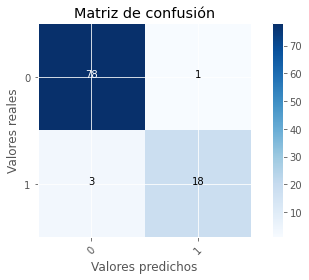

In [ ]:
# Información del modelo - Coeficientes y Medidas de desempeño
Coef_RL = coef_rl(modelo,X)
print(' ')
Ind_RL = indicadores_rl(y_test,y_pred)
# df_new = pd.DataFrame(SelectKBest(chi2, k=10).fit_transform(df.drop(["BAD"],axis = 1),df["BAD"]))

### 8.4. Predicción bajo validación cruzada (Cross Validation)

Sobre esquema de validación cruzada:

https://scikit-learn.org/stable/_images/grid_search_cross_validation.png

---


In [ ]:
# Validación cruzada (para predicción, no probabilística).
y_cross_val_predict = cross_val_predict(modelo, X_train,y_train,cv=5)
print(y_cross_val_predict)
# PONER LOS VALORES PREDICHOS CON LOS REALES PARA COMPARAR.

## 9. Ajuste de modelo de Regresión Logística con Statmodels.

Este paso utiliza el modelo de la librería Statmodels para comparar con el modelo dado por Scikit Learn. Los valores cambiarán de acuerdo con el porcentaje asignado a datos de entrenamiento y datos de prueba.

---



In [ ]:
# Modelo de Statmodels
# Aqúi trabajamos de otra forma.
X_stats = pd.DataFrame(X_train)
X_stats = sm.add_constant(X_stats, prepend=True)
X_stats.columns = ['Intercepto'] + X.columns.to_list()
X_stats
modelo_stats = sm.Logit(endog=y_train, exog=X_stats)
modelo_stats = modelo_stats.fit()
print(modelo_stats.summary())

## 10. Ajuste de modelo con Árboles de Decisión.

Este paso utiliza el modelo de la librería Statmodels para comparar con el modelo dado por Scikit Learn. Los valores cambiarán de acuerdo con el porcentaje asignado a datos de entrenamiento y datos de prueba.

---


### 10.1. Creación del modelo.

Generación de modelo, ajuste y predicción de datos de prueba.

---

In [ ]:
# Creación de modelo como objeto de Árbol de Decisión.
modelo_arbol = DecisionTreeClassifier(
    ccp_alpha=0.0,
    class_weight=None,
    criterion='gini',
    max_depth=None,
    max_features=None,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    min_samples_leaf=1,
    min_samples_split=2,
    min_weight_fraction_leaf=0.0,
    presort='deprecated',
    random_state=None,
    splitter='best'
    )
# Training the basic Decision Tree model with training set 
modelo_arbol.fit(X_train,y_train)
y_pred_arbol = modelo_arbol.predict(X_test)

### 10.2. Información del modelo

Se calculan para el modelo las medidas de desempeño, de acuerdo con la matriz de confusión, así como la significancia (a través del test de Wald) de las variables en el modelo.

---

In [ ]:
Ind_arbol = indicadores_rl(y_test,y_pred_arbol)

In [ ]:
# Graficar un árbol de decisión.
dot_dat = tree.export_graphviz(modelo_arbol, out_file=None) 
graph = graphviz.Source(dot_dat) 
graph